In [48]:
import sys
sys.path.append("..")
import os

import lauetools.LaueTools.IOimagefile as IOimage

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy import fft

from sklearn import metrics
from sklearn import cluster
from sklearn.feature_extraction.image import grid_to_graph

sx,sy=50,50

def reduce(im, sx, sy, lp, hp):
    SX, SY = im.shape
    im_ = im.reshape(sx, SX // sx, sy,SY // sy).mean(-1).mean(1)
    #ss=cv2.dct(im_)
    ss=fft.dctn(im_)
    ss[:lp, :] = 0.
    ss[:, :lp] = 0.
    ss[hp:, :] = 0.
    ss[:, hp:] = 0.
    #return cv2.idct(ss), ss[lp: hp, lp: hp].ravel()
    return fft.idctn(ss), ss[lp: hp, lp: hp].ravel()

features=np.load('100_features4096.npy')[1:1+sx,25:25+sy,:]
#features=np.load('100_features4096.npy')[:sx,30:30+sy,:]
X = np.reshape(features, (sx*sy,4096))
print(X.shape)

connectivity = grid_to_graph(n_x=64, n_y=64)

agglo = cluster.FeatureAgglomeration(connectivity=connectivity, n_clusters=256)

agglo.fit(X)
fa_features=agglo.transform(X)

(2500, 4096)


In [49]:
connectivity = grid_to_graph(n_x=sx, n_y=sy)

(2500,)


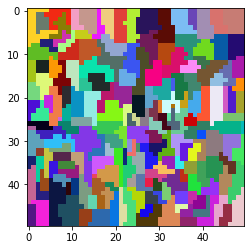

In [50]:
n_clusters_=200

ward = cluster.AgglomerativeClustering(n_clusters=n_clusters_, connectivity=connectivity, linkage='ward').fit(fa_features)

labels = ward.labels_
print(labels.shape)
grains=labels.reshape((sx,sy))
colors=np.random.uniform(size=(n_clusters_,3))
sample_silhouette_values = metrics.silhouette_samples(fa_features, labels)
sample_silhouette_values=sample_silhouette_values.reshape((sx,sy))

im=np.zeros(tuple(list(grains.shape)+[3]))

for i in range(sx):
    for j in range(sy):
        if sample_silhouette_values[i,j] > 0:
            im[i,j]=colors[grains[i,j]]
        else:
            im[i,j]=colors[grains[i,j]]#np.array([1.,1.,1.])
plt.imshow(im)

#print(metrics.silhouette_score(pca_features, labels))#, metric='euclidean'))

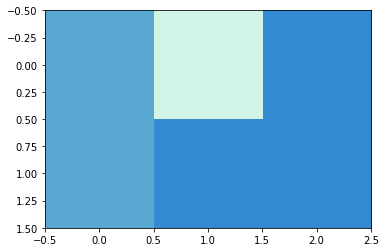

In [41]:

plt.imshow(im[0:2,18:21,:])


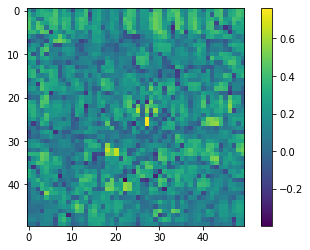

In [22]:
plt.imshow(sample_silhouette_values)
plt.colorbar()

0.0908
0.20885676488334665


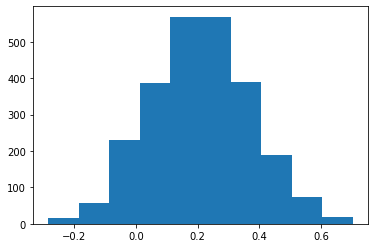

In [8]:
plt.hist(sample_silhouette_values.ravel())

xx=sample_silhouette_values.ravel()
print(xx[xx<0].shape[0]/xx.shape[0])
print(metrics.silhouette_score(fa_features, labels))

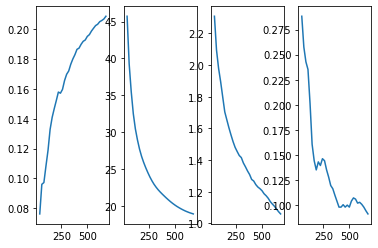

In [9]:
nums=range(40,700,20)
sil=[]
cal_har=[]
dav_bou=[]
frac=[]
for n_clusters_ in nums:
    ward = cluster.AgglomerativeClustering(n_clusters=n_clusters_, connectivity=connectivity, linkage='ward').fit(fa_features)
    labels = ward.labels_
    sil.append(metrics.silhouette_score(fa_features, labels))#, metric='euclidean'))
    cal_har.append(metrics.calinski_harabasz_score(fa_features, labels))#, metric='euclidean'))
    dav_bou.append(metrics.davies_bouldin_score(fa_features, labels))#, metric='euclidean'))
    sample_silhouette_values = metrics.silhouette_samples(fa_features, labels)
    xx=sample_silhouette_values.ravel()
    frac.append(xx[xx<0].shape[0]/xx.shape[0])
plt.subplot(1,4,1)
plt.plot(nums,sil)

plt.subplot(1,4,2)
plt.plot(nums,cal_har)

plt.subplot(1,4,3)
plt.plot(nums,dav_bou)

plt.subplot(1,4,4)
plt.plot(nums,frac)